In this part we will be looking into using GPU acceleration. In Google Colab, you need to request a GPU-enabled runtime by going to `Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU`.

In [1]:
import torch
import matplotlib.pyplot as plt
import skimage
import numpy as np

# Creating tensors

PyTorch tensors are very close to numpy.ndarray, with similar functions for creating and manipulating arrays as well as functionality for a direct conversion between `numpy.ndarray` and `torch.tensor`.

## From scratch

Some of the most commonly used methods for constructing tensor from scratch are:

- [`torch.zeros`](https://pytorch.org/docs/stable/generated/torch.zeros.html)
- [`torch.ones`](https://pytorch.org/docs/stable/generated/torch.ones.html)
- [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html) / [`torch.randn`](https://pytorch.org/docs/stable/generated/torch.randn.html) (uniformly/normally distributed random numbers)

A full list of such methods can be found in the [docs](https://pytorch.org/docs/stable/torch.html#creation-ops).

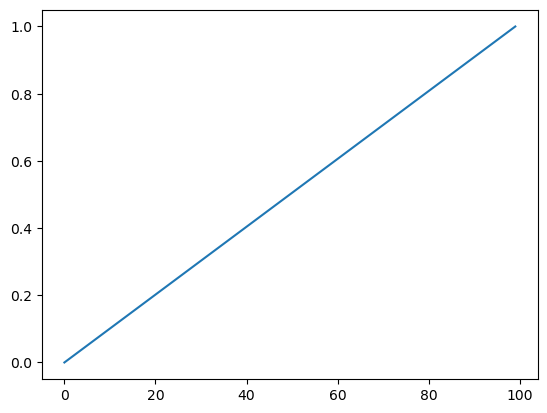

In [2]:
x = torch.linspace(start=0.0, end=1.0, steps=100)
plt.plot(x)

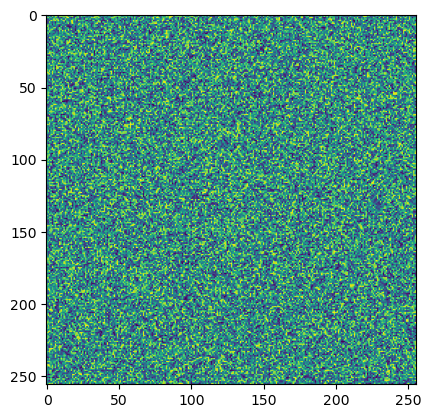

In [3]:
x = torch.rand(size=[256, 256])
plt.imshow(x)

## From NumPy arrays

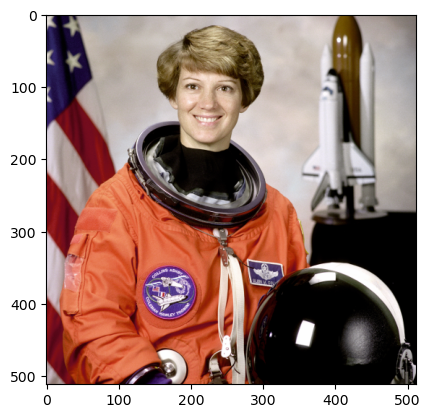

In [4]:
im = skimage.data.astronaut()
im_torch = torch.tensor(im)
plt.imshow(im)

## And back to NumPy...

In [5]:
type(im_torch.numpy())

numpy.ndarray

# Tensor properties

In [6]:
print('Tensor rank:', im_torch.ndim)
print('Tensor shape:', im_torch.shape)
print('Tensor datatype:', im_torch.dtype)

Tensor rank: 3
Tensor shape: torch.Size([512, 512, 3])
Tensor datatype: torch.uint8


# Math operations and linear algebra

PyTorch offers a wide range of optimized [math operations](https://pytorch.org/docs/stable/torch.html#math-operations) and [linear algebra functionality](https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations), serving as the working horse of computational pipelines.


## Pointwise operations ([docs](https://pytorch.org/docs/stable/torch.html#pointwise-ops))

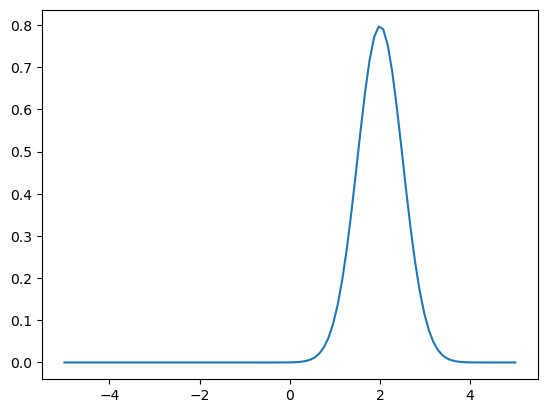

In [7]:
x = torch.linspace(start=-5.0, end=5.0, steps=100)
mu = 2.0
sigma = 0.5
gaussian = 1 / (sigma * (2 * torch.pi)**0.5) * torch.exp(-(x - mu)**2 / (2 * sigma**2))

plt.plot(x, gaussian)

# Reduction operations  ([docs](https://pytorch.org/docs/stable/torch.html#reduction-ops))

In [8]:
x = torch.randn(256)

print('Mean:', torch.mean(x))
print('Standard deviation:', x.std())
print('L2 norm:', torch.sqrt(torch.sum(x**2)))

Mean: tensor(0.1254)
Standard deviation: tensor(0.9993)
L2 norm: tensor(16.0825)


# FFT ([docs](https://pytorch.org/docs/stable/fft.html))

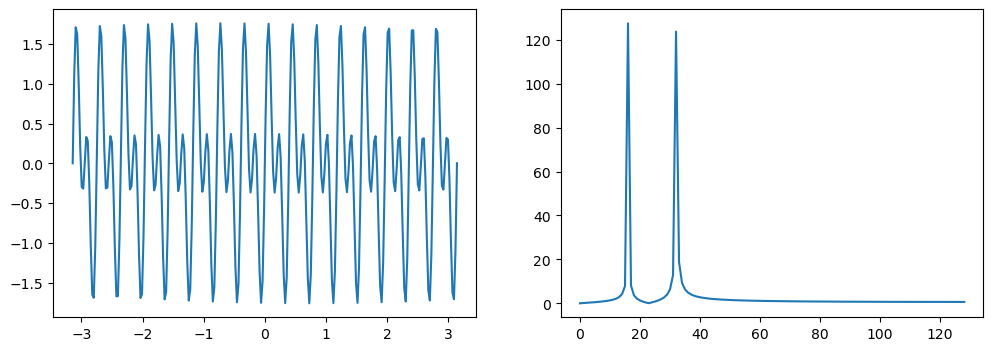

In [9]:
x = torch.linspace(start=-torch.pi, end=torch.pi, steps=256)
waveform = torch.sin(16*x) + torch.sin(32*x)
frequencies = torch.fft.fftfreq(n=256)
spectrum = torch.abs(torch.fft.rfft(waveform))

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(x, waveform)
plt.subplot(1, 2, 2)
plt.plot(spectrum)

## [Linear algebra](https://pytorch.org/docs/stable/linalg.html#)

\+ [low-level calls to the underlying BLAS/LAPACK routines](https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations).

In [10]:
A = torch.randn(5, 256)
x = torch.randn(256)
print(torch.matmul(A, x))
print(A @ x)  # Syntax equivalent to matmul

tensor([-13.9953,   1.9893,  -8.1767,  -4.4917, -18.5483])
tensor([-13.9953,   1.9893,  -8.1767,  -4.4917, -18.5483])


In [11]:
print(torch.linalg.matrix_norm(A))
print(torch.linalg.vector_norm(A @ x))

tensor(35.7875)
tensor(25.1178)


An interesting function for doing generic tensor operations is [`einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html), which implements Einstein's summation convention. Let's use it to convert an RGB image to grayscale by computing it's tensor product with per-channel weights defined in [CIE 1931 standard](https://en.wikipedia.org/wiki/CIE_1931_color_space).

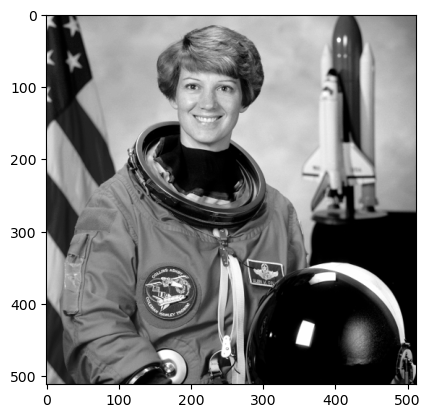

In [12]:
im = torch.tensor(skimage.data.astronaut(), dtype=torch.float32)
cie1931_weigths = torch.tensor([0.2126, 0.7152, 0.0722])
im_grayscale = torch.einsum('ijk,k->ij', im, cie1931_weigths)

plt.imshow(im_grayscale, cmap='gray')

# GPU acceleration

A great selling point of PyTorch is that most of mathematical operations are also implemented for GPU execution. To use GPU acceleration, one needs to create or transfer the relevant tensors to a GPU device (which in PyTorch are called `cuda`, even if you use [experimental AMD GPU support](https://pytorch.org/docs/stable/notes/hip.html)). The device where a tensor resides is indicated by the `.device` property of the tensor.

For GPU tensors, accelerated operations are applied automatically, so typically no code needs to be changed to port a computation to GPU besides transferring tensors. Which is great!

To use GPU acceleration in Google Colab, you need to request a GPU-enabled runtime by going to `Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU` in case you haven't done so already.

## Create a tensor on GPU:

In [13]:
x = torch.randn(256, 256, device='cuda')
print(x.device)

cuda:0


or transfer a CPU tensor:

In [14]:
im = torch.tensor(skimage.data.astronaut())
im = im.cuda()  # or im = im.to('cuda')

Note that transferring data between `.cpu()` and `.cuda()` is consumes some time and can even negate the benifit of GPU acceleration in some situations.

## Let's compare the speed between GPU and CPU

In [15]:
A = torch.rand(4096, 4096)
x = torch.rand(4096)

A_cuda = A.cuda()
x_cuda = x.cuda()

In [16]:
%%timeit
torch.mean(A @ x)

1.81 ms ± 22.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%%timeit
torch.mean(A_cuda @ x_cuda)
torch.cuda.synchronize()  # GPU functions return immediately, so we synchronize here for a correct timing

227 μs ± 234 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Datatypes and GPU performance

PyTorch offers [a range of datatypes](https://pytorch.org/docs/stable/tensors.html#data-types) for tensors, like integer and floating point numbers with different precision, complex numbers and booleans. The datatypes can be converted using `.to()` method.

The precision of a given datatype influences memory requirements and computational performance of mathematical operations. For GPUs, operations on single precision (`torch.float32`) tensors will be significantly faster than on double precision (`torch.float64`). This is something to be aware of, since the "default" datatype for NumPy floating-point arrays is double precision.

In [18]:
x = np.random.rand(256, 256)
x = torch.tensor(x)
print(x.dtype)

torch.float64


Let's compare how it influences computational performance

In [19]:
A_float64 = A = torch.rand(4096, 4096, device='cuda', dtype=torch.float64)
x_float64 = torch.rand(4096, device='cuda', dtype=torch.float64)

A_float32 = A_float64.to(torch.float32)
x_float32 = x_float64.to(torch.float32)

In [20]:
%%timeit
torch.mean(A_float64 @ x_float64)
torch.cuda.synchronize()

436 μs ± 266 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
torch.mean(A_float32 @ x_float32)
torch.cuda.synchronize()

227 μs ± 727 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Execution model

Unlike some other popular deep learning frameworks (e.g. [TensorFlow](https://www.tensorflow.org/) and [JAX](https://jax.readthedocs.io/en/latest/)), PyTorch more closely follows the concepts of Python and NumPy. For example, you get a tensor result directly after executing a function on a tensor (intead of constructing and executing a graph of operations), and you can modify the data for any given tensor in-place. This makes it more intuitive to translate existing Python/NumPy codes into PyTorch framework. Of course, there is a flipside, which is more limited code analysis and therefore potentially worse performance. To address this, [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html) functionality has been developed, which can be used to optimize a PyTorch program for a higher performance.

In [22]:
x = torch.arange(start=0, end=10)
print(x)
x[0:5] += 1
print(x)
x *= 2
print(x)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([1, 2, 3, 4, 5, 5, 6, 7, 8, 9])
tensor([ 2,  4,  6,  8, 10, 10, 12, 14, 16, 18])


# Exercises

## Power iteration algorithm

[Power iteration](https://en.wikipedia.org/wiki/Power_iteration) is a simple algorithm for calculating the largest (in absolute value) eigenvalue and the corresponding eigenvector of a diagonizable matrix. The algorithm is defined by the following recurrence relation:

$$b_{k+1} = \frac{Ab_k}{\|Ab_k\|}$$

where $b_0$ can be initialized as a random vector. This sequence converges to the eigenvector corresponding to the largest eigenvalue, which can be computed as the Rayleigh quotient:

$$\lambda = \frac{b_k^\top A b_k}{b_k^\top b_k}$$

Implement this algorithm using PyTorch functions, and test running it for 10 iterations on a set of random positive square matrices, for which the existence of a unique positive real eiganvalue is guaranteed by the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem).

In [ ]:
def power_iteration(A, n_iter=10):
    # Fill in your implementation here
    pass

# Check the solution empirically
for _ in range(100):
    A = torch.rand(256, 256)
    largest_eigenval = power_iteration(A)
    eigenvals_torch = torch.linalg.eigvals(A).real
    largest_eigenval_torch = eigenvals_torch[torch.argmax(eigenvals_torch.abs())]
    assert torch.allclose(largest_eigenval, largest_eigenval_torch)

### Solution

In [ ]:
def power_iteration(A, n_iter=10):
    b = torch.rand(A.shape[1], device=A.device, dtype=A.dtype)
    for _ in range(n_iter):
        Ab = A @ b
        b = Ab / torch.norm(Ab)
    lam = b.dot(A @ b)
    return lam

## Random projections

According to [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma), it is possible to project a set of points from highly-dimensional onto low-dimensional Euclidean space while probabilistically preserving distances between them with to a cetain degree. In this exercise, we will explore such projections using random Gaussian matrices, and empirically test how the number of input and output dimensions influences the distance distortion.

1. For a pair of vectors in N-dimensional space, compute the Euclidean distance between them, calculate their projection onto M-dimensional space using a random Gaussian matrix drawn from $\mathcal{N}(0, \frac{1}{\sqrt{M}})$ distribution, and compute the distance between the projected points. Compare the distances in the N-dimensional and the M-dimensional spaces. Suggested dimensions to try are ($N = 10^4$, $M = 10$), ($N = 10^5$, $M = 10^5$), ($N = 10^5$, $M = 10^4$), ($N = 10^2$, $M = 10$).
2. Plot the dependency of the relative error between the distances in the N-dimensional and M-dimensional spaces as a function of N and M on a double-logarithmic scale. Average between a number of trials to get less noisy results.

**Note:** GPU acceleration makes things much faster in this exercise, but you need to be conscious about the amount of GPU memory. It is helpful to delete the projection matrix after you don't need it anymore using Python's `del` operator to free up some GPU memory.  

### Solution

In [ ]:
Ns = 10**torch.tensor([1, 2, 3, 4, 5])
Ms = 10**torch.tensor([1, 2, 3, 4])
n_trials = 100
rel_errors = torch.zeros(size=[len(Ns), len(Ms)], device='cuda')
for i, N in enumerate(Ns):
    for j, M in enumerate(Ms):
        for _ in range(n_trials):
            x = torch.randn(N, dtype=torch.float32, device='cuda')
            y = torch.randn(N, dtype=torch.float32, device='cuda')
            distance_in_N = torch.linalg.norm(x - y)
            A = torch.randn(size=[M, N], dtype=torch.float32, device='cuda') / M**0.5
            distance_in_M = torch.linalg.norm(A@x - A@y)
            del A  # Free up CUDA memory
            rel_errors[i, j] += abs((distance_in_N - distance_in_M) / distance_in_N )
rel_errors /= n_trials

plt.loglog(Ns, rel_errors.cpu())
plt.legend(Ms.numpy(), title='M')
plt.xlabel('N')
plt.ylabel('Relative error')

Note that the relative error is very insensitive to the number of input dimensions $N$. This means that random projection is a very useful method for dimensionality reduction when we are interested in distances between points. Even extremely highly-dimensional inputs will be projected with little distortion. On the other hand, it means that projecting low-dimensional inputs doesn't help much, since we need a given number of output dimension $M$ to preserve distances with random projection. It's not always compressing data!

See also [an interesting empirical analysis](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_johnson_lindenstrauss_bound.html#sphx-glr-auto-examples-miscellaneous-plot-johnson-lindenstrauss-bound-py) and [even simpler / more efficient projection methods](https://scikit-learn.org/stable/modules/random_projection.html) in the examples from `scikit-learn`.